# Model Training

Here We will further work on our Dataset and make it ready for model Training.

### Procedure:
- Correlation analysis(heatmap/statsmodel VIF)
- Splitting The Dataset
- Data/scaling and Normalization
- Model Training (Regression)
- Model Evaluation and Hyperparameter tuning
- Model Selection


In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#machine learning preprocessing techniques
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine learning libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Evaluation metrics
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Read the Cleaned Dataset
df = pd.read_csv('Cleaned_dataset.csv')
df.head()

,fare_amount,passenger_count,time_of_day,distance,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,7.5,1,Evening,1.68,19,3,5,2015
1,7.7,1,Evening,2.45,20,4,7,2009
2,12.9,1,Night,5.04,21,0,8,2009
3,5.3,3,Morning,1.66,8,4,6,2009
4,16.0,5,Evening,4.48,17,3,8,2014


In [37]:
df['time_of_day'].unique()

array(['Evening', 'Night', 'Morning', 'Afternoon'], dtype=object)

## Correlation analysis


<function matplotlib.pyplot.show(close=None, block=None)>

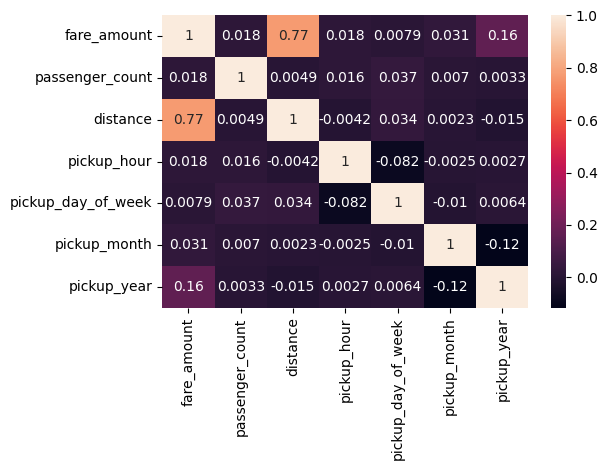

In [3]:
sns.heatmap(df[df.select_dtypes(exclude='object').columns].corr(), annot=True)
plt.tight_layout()
plt.show

## Insights

- Distance is the strongest predictor of fare amount. This emphasizes that distance is the primary driver for fare pricing.
- Temporal features (hour, day, year) show little to no influence on fare directly, but pickup year could suggest incremental fare increases over time.
- Passenger count has minimal impact on fare, indicating that the number of riders doesn’t heavily influence pricing.

## Splitting the dataset

we will split the dataset into train and test part. This helps us to evaluate the model.

In [4]:
# Independent and Dependent variable
X = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']

# utilizing train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=42)

print(f'The dimension of the  training set: {X_train.shape}')
print(f'The dimension of the  testing set: {X_test.shape}')
print(f'The dimension of the original set: {df.shape}')

The dimension of the  training set: (130156, 7)
The dimension of the  testing set: (32539, 7)
The dimension of the original set: (162695, 8)


## Data Normalization & Transforming categorical features

Data Normalization: It helps in scaling all the feature to a similar range that helps in effeciant learning of the model

Transformation: it helps transforming categorical features to numerical features that helps the model to learn its significance.

In [5]:
# utilizing columntransformer tobuild a pipeline
cat_features = ['time_of_day']
num_features = X.select_dtypes(exclude='object').columns

oh_transformer = OneHotEncoder()
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(

    [

        ('OneHot Encoding', oh_transformer, cat_features),
        ('Standard Scaling', num_transformer, num_features)
    ], remainder='passthrough'
)


In [6]:
# fit transforming X_train
X_train = preprocessor.fit_transform(X_train)

# transform X_test (not fit_transform in testing set to prevent data leakage)
X_test = preprocessor.transform(X_test)

In [38]:
# Get one-hot encoded feature names
encoded_cat_features = preprocessor.named_transformers_['OneHot Encoding'].get_feature_names_out(cat_features)

# Combine with numerical features
all_feature_names = list(encoded_cat_features) + list(num_features)

# Create DataFrame
X_train_df = pd.DataFrame(X_train, columns=all_feature_names)

X_train_df.head()

,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,passenger_count,distance,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,0.0,1.0,0.0,0.0,0.239454,-1.203857,0.527338,-1.047096,-0.073526,0.700595
1,0.0,0.0,1.0,0.0,-0.527059,-0.839967,-1.036005,-1.562240,-1.524336,-0.913366
2,0.0,1.0,0.0,0.0,0.239454,-0.040994,0.996341,-1.047096,-0.363688,-0.375379
3,0.0,0.0,1.0,0.0,-0.527059,-0.365329,-1.192339,-1.562240,0.506798,0.700595
4,1.0,0.0,0.0,0.0,1.772481,-0.586827,0.058335,-0.531953,-0.944012,-0.913366


In [7]:
X_train

array([[ 0.        ,  1.        ,  0.        , ..., -1.04709646,
        -0.07352588,  0.70059523],
       [ 0.        ,  0.        ,  1.        , ..., -1.5622401 ,
        -1.52433606, -0.91336627],
       [ 0.        ,  1.        ,  0.        , ..., -1.04709646,
        -0.36368791, -0.3753791 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.52862175,
         1.08712227, -0.3753791 ],
       [ 0.        ,  0.        ,  1.        , ..., -1.04709646,
        -1.52433606, -0.3753791 ],
       [ 0.        ,  0.        ,  1.        , ...,  0.49833447,
         0.79696023,  0.16260806]], shape=(130156, 10))

In [8]:
X_test

array([[ 0.        ,  0.        ,  0.        , ...,  1.52862175,
         1.3772843 , -0.91336627],
       [ 0.        ,  0.        ,  0.        , ...,  1.52862175,
         1.08712227, -0.91336627],
       [ 0.        ,  0.        ,  0.        , ..., -0.53195282,
        -0.65384995,  0.16260806],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.52862175,
         1.08712227, -0.3753791 ],
       [ 0.        ,  0.        ,  1.        , ..., -0.01680918,
         0.21663616, -1.45135344],
       [ 0.        ,  0.        ,  1.        , ..., -1.04709646,
         0.5067982 ,  0.70059523]], shape=(32539, 10))

## Training the Model

Here we will Train and evaluate the Model Followed by Hyperparameter tuning to make our model more accurate.

In [9]:
## Creating a function that will evaluate model 

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = root_mean_squared_error(true, predicted)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [27]:
# Utilising different models to see their base scores.
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boost': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'Support Vector Regressor': SVR(kernel='rbf')

}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train Model

    # Make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Evaluate Train and Test Dataset (evaluating with both train and test dependent variables are important to check if the model is overfitting or not.)
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print("Model Performance for Training Set")
    print(f'- Root Mean Squared Error: {model_train_rmse}')
    print(f'- Mean Absolute Error: {model_train_mae}')
    print(f'- R2 Score: {model_train_r2}')

    print('------------------------------------------------------------------------')

    print("Model Performance for Testing Set")
    print(f'- Root Mean Squared Error: {model_test_rmse}')
    print(f'- Mean Absolute Error: {model_test_mae}')
    print(f'- R2 Score: {model_test_r2}')

    r2_list.append(model_test_r2)

    print('='*50)
    print('\n')



Linear Regression
Model Performance for Training Set
- Root Mean Squared Error: 1.9507220750210343
- Mean Absolute Error: 1.4245866166560917
- R2 Score: 0.6300434015275717
------------------------------------------------------------------------
Model Performance for Testing Set
- Root Mean Squared Error: 1.9277561283268423
- Mean Absolute Error: 1.406726712837924
- R2 Score: 0.6322133488358433


Lasso Regression
Model Performance for Training Set
- Root Mean Squared Error: 2.281899587852295
- Mean Absolute Error: 1.782136628284032
- R2 Score: 0.4937639832481113
------------------------------------------------------------------------
Model Performance for Testing Set
- Root Mean Squared Error: 2.2553650254062974
- Mean Absolute Error: 1.762091528472723
- R2 Score: 0.4965858014475293


Ridge Regression
Model Performance for Training Set
- Root Mean Squared Error: 1.950620345490041
- Mean Absolute Error: 1.424461870402043
- R2 Score: 0.6300819867575154
------------------------------------

In [29]:
pd.DataFrame(list(zip(model_list, r2_list)), columns = ['Model name','R2 Score']).sort_values(by=['R2 Score'], ascending=False)

,Model name,R2 Score
6,Gradient Boost,0.675962
7,XGBRegressor,0.675448
8,Support Vector Regressor,0.659463
5,Random Forest Regressor,0.639884
0,Linear Regression,0.632213
2,Ridge Regression,0.632193
1,Lasso Regression,0.496586
3,Elastic Net,0.466725
4,Decision Tree Regressor,0.302150


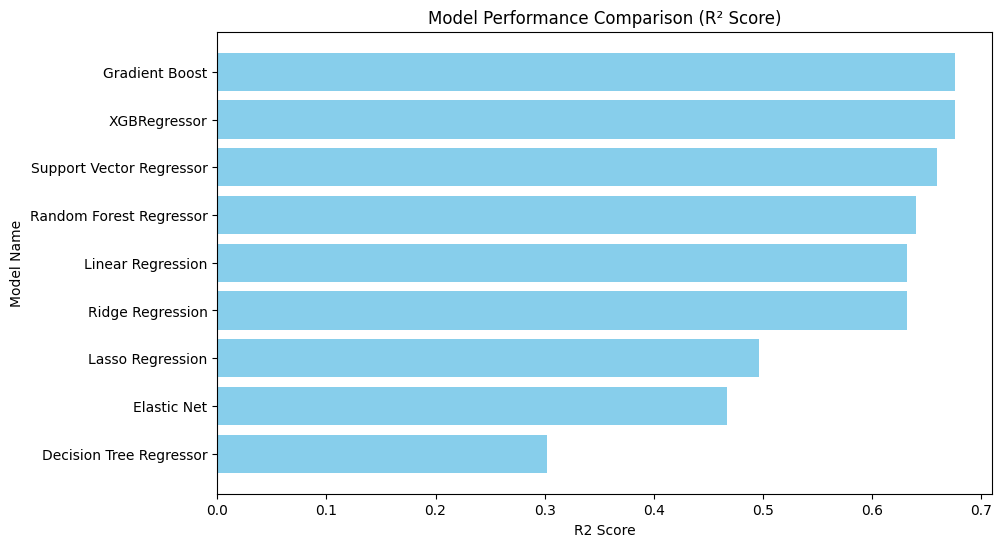

In [30]:
# Create DataFrame from model names and R² scores
models_dataframe= pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model name', 'R2 Score']).sort_values(by=['R2 Score'], ascending=False)

# Plotting the R² scores
plt.figure(figsize=(10, 6))
plt.barh(models_dataframe['Model name'], models_dataframe['R2 Score'], color='skyblue')
plt.xlabel('R2 Score')
plt.ylabel('Model Name')
plt.title('Model Performance Comparison (R² Score)')
plt.gca().invert_yaxis()  # Invert y-axis to show the best model on top
plt.show()

## Hyperparameter Tuning

based on the r2 dataframe scoreswe will choose the top 2 model for hyperparameter tuning that are performing very well:

- Gradient Boost
- XGBRegressor


In [12]:
# Initializing the parameters

xg_params = {
    'booster': ['gbtree','gblinear'],
    'n_estimators': [100,200],
    'learning_rate':[0.01,0.1],
    'max_depth': [3,7],
    'subsample': [0.8,1.0],
    'colsample_bytree': [0.8,1.0],
    'gamma': [0,0.1],
    'reg_lambda': [0.001,0.1,1],
    'objective': ['reg:squarederror','reg:squaredlogerror','reg:pseudohubererror', 'reg:absoluteerror']
    }

gradient_params = {
    'n_estimators': [100, 200, 300],             
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     
    'max_depth': [3, 4, 5, 6],                   
    'min_samples_split': [2, 5, 10],             
    'min_samples_leaf': [1, 3, 5],               
    'subsample': [0.7, 0.8, 1.0],                
    'max_features': ['sqrt', 'log2', None]       
}
randomcv_model = [
    ('XGB', XGBRegressor(), xg_params),
    ('gradient boost', GradientBoostingRegressor(), gradient_params),
    
]

for name, model, params in randomcv_model:
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=100,
                                cv=3,
                                scoring='neg_mean_squared_error',
                                verbose=2,
                                n_jobs=-1
                                )

    random.fit(X_train, y_train)
    model_param = random.best_params_
    print(model_param)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 1.0, 'reg_lambda': 1, 'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8, 'booster': 'gbtree'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.05}


In [31]:
# Utilising different models to see their base scores.
models = {
    'Gradient Boost': GradientBoostingRegressor(subsample= 0.8, n_estimators=300, min_samples_split= 5, min_samples_leaf=5, max_features= 'sqrt', max_depth=5, learning_rate=0.05),
    'XGBRegressor': XGBRegressor(objective= 'reg:squarederror', reg_lambda = 1, booster='gbtree',subsample =1.0, n_estimators =300, learning_rate=0.1, max_depth =7, gamma=0.1, colsample_bytree=0.8)}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train Model

    # Make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Evaluate Train and Test Dataset (evaluating with both train and test dependent variables are important to check if the model is overfitting or not.)
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print("Model Performance for Training Set")
    print(f'- Root Mean Squared Error: {model_train_rmse}')
    print(f'- Mean Absolute Error: {model_train_mae}')
    print(f'- R2 Score: {model_train_r2}')

    print('------------------------------------------------------------------------')

    print("Model Performance for Testing Set")
    print(f'- Root Mean Squared Error: {model_test_rmse}')
    print(f'- Mean Absolute Error: {model_test_mae}')
    print(f'- R2 Score: {model_test_r2}')

    r2_list.append(model_test_r2)

    print('='*50)
    print('\n')


Gradient Boost
Model Performance for Training Set
- Root Mean Squared Error: 1.7864633502632885
- Mean Absolute Error: 1.2881913404888687
- R2 Score: 0.6897239868343745
------------------------------------------------------------------------
Model Performance for Testing Set
- Root Mean Squared Error: 1.7977960852474477
- Mean Absolute Error: 1.294385442104404
- R2 Score: 0.6801306421945565


XGBRegressor
Model Performance for Training Set
- Root Mean Squared Error: 1.7199466094511229
- Mean Absolute Error: 1.244020821095656
- R2 Score: 0.7123993177237765
------------------------------------------------------------------------
Model Performance for Testing Set
- Root Mean Squared Error: 1.8023338213116513
- Mean Absolute Error: 1.2983630447870702
- R2 Score: 0.6785138686975749




## Evaluation

- Gradient Boosting showed an incredible performance metrics. r2score of 0.68 approx in bothe training and testing.
- Gradient boosting also showed less overfitting issue compared to xgboost or randomforest showing the reliability of the model.


## Feature Importance

importance of each feature in predicting the fare amount

In [34]:
importance =model.feature_importances_

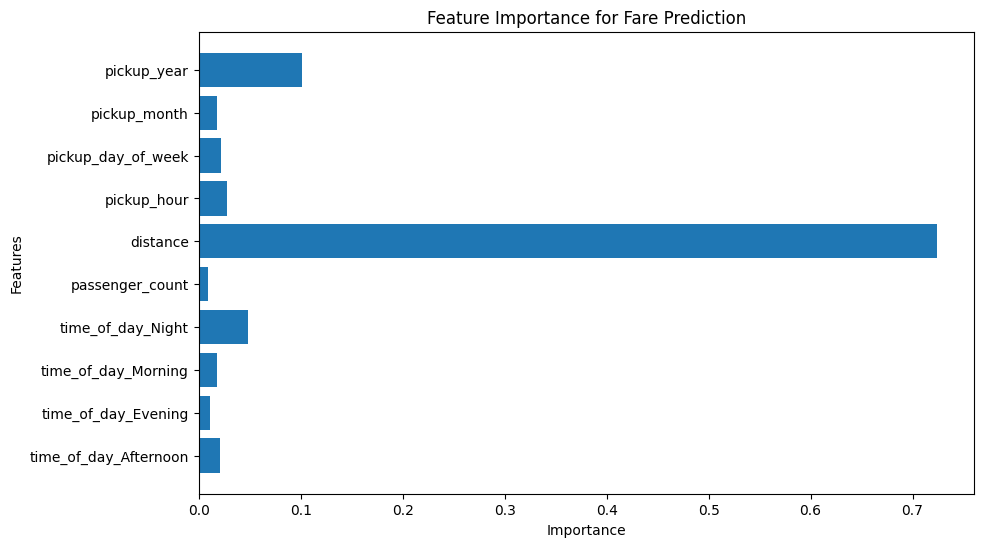

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X_train_df.columns, importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Fare Prediction')
plt.show()

# Insights

- Distance is the dominant feature.
- pickup Year shows moderate importance. This might indicate fare variations over different years
- Time of Day has some influence on the price.
- Low importance features:
    - pickup month
    - pickup day of week
    - pickup hour
    - passenger count
    